# Machine Learning Models

## Import libraries

In [153]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score,roc_auc_score, precision_score, roc_curve
from sklearn.metrics import recall_score, jaccard_score, log_loss, confusion_matrix
from sklearn.model_selection import GridSearchCV
import scikitplot
import shap

## Import Data

In [154]:
data = pd.read_csv("processed_train.csv")
test_data = pd.read_csv('processed_test.csv')

In [155]:
data.head(1)

Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0       0              0   43               0      0             3603   

   Inflight wifi service  Departure/Arrival time convenient  \
0                      2                                  2   

   Ease of Online booking  Gate location  Food and drink  Online boarding  \
0                       2              2               1                1   

   Seat comfort  Inflight entertainment  On-board service  Leg room service  \
0             1                       4                 4                 4   

   Baggage handling  Checkin service  Inflight service  Cleanliness  \
0                 4                3                 4            1   

   Arrival Delay in Minutes  satisfaction  
0                       0.0             1

In [156]:
test_data.head(1)

Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0       0              0   52               0      1              160   

   Inflight wifi service  Departure/Arrival time convenient  \
0                      4                                  3   

   Ease of Online booking  Gate location  Food and drink  Online boarding  \
0                       2              3               2                3   

   Seat comfort  Inflight entertainment  On-board service  Leg room service  \
0             2                       4                 4                 4   

   Baggage handling  Checkin service  Inflight service  Cleanliness  \
0                 4                1                 4            4   

   Arrival Delay in Minutes  satisfaction  
0                      44.0             1

In [157]:
X_train = data.drop('satisfaction', axis = 1)
y_train = data.satisfaction

X_test = test_data.drop('satisfaction', axis=1)
y_test = test_data.satisfaction

## Feature Scaling

In [158]:
s = StandardScaler()
X_train_scal = s.fit_transform(X_train)
X_test_scal = s.transform(X_test)

In [159]:
X_train_scal

array([[-0.98436197, -0.45950547,  0.22559353, ...,  1.11782492,
        -1.0335488 , -0.53359716],
       [ 1.01588647, -0.45950547,  0.35976856, ..., -2.31471994,
         0.50394959, -0.53359716],
       [ 1.01588647, -0.45950547, -0.57945668, ...,  0.2596887 ,
         1.27269878, -0.53359716],
       ...,
       [ 1.01588647,  2.17625264, -0.64654419, ...,  1.11782492,
         0.50394959,  1.43935958],
       [-0.98436197,  2.17625264, -1.18324433, ...,  0.2596887 ,
        -1.80229799, -0.53359716],
       [ 1.01588647, -0.45950547, -0.84780675, ..., -0.59844751,
        -1.80229799, -0.53359716]])

## 1- K-Nearest Neigbors Classifier

We know that the Algorithms that use gradient descent (linear regression, logistic regression, and neural network) along with algorithms that use euclidean distance (K Nearest Neighbors, K-Means clustering, and Support Vector Machine) require the features to be scaled.

In [160]:
knn = KNeighborsClassifier(n_neighbors= 3)
knn.fit(X_train_scal, y_train)
k = KFold(n_splits = 5)
score = cross_val_score(knn, X_train_scal, y_train, scoring = 'accuracy', cv = k).mean()
print("Accuracy on the training set:", round(score, 3))

Accuracy on the training set: 0.902


In [161]:
y_pred = knn.predict(X_test_scal)
print("Accuracy on the test set:", round(accuracy_score(y_test, y_pred), 3))

Accuracy on the test set: 0.909


In [162]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     14573
           1       0.91      0.88      0.90     11403

    accuracy                           0.91     25976
   macro avg       0.91      0.91      0.91     25976
weighted avg       0.91      0.91      0.91     25976



### Choosing the best K value (number of neighbors)

In [163]:
accuracy = []
for i in range(1,25):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scal,y_train)
    pred_i = knn.predict(X_test_scal)
    accuracy_i = accuracy_score(y_test, pred_i)
    accuracy.append(accuracy_i)

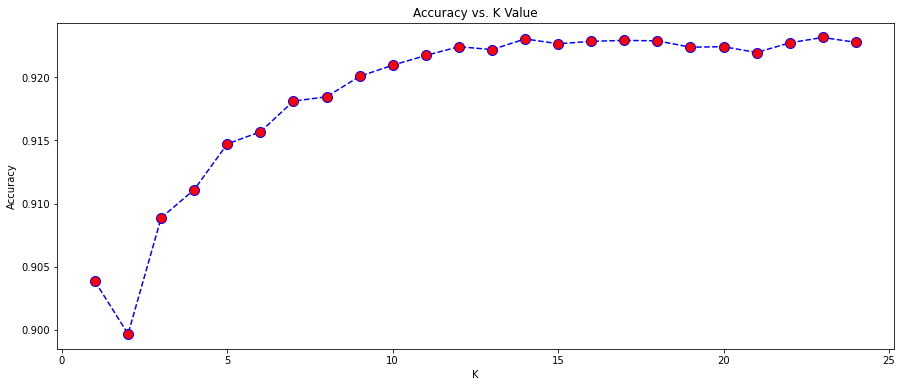

In [164]:
plt.figure(figsize=(15,6))
plt.plot(range(1,25, 1), accuracy, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

From the graph we can see k = 10 gives a good accuracy, so let's train our model for k = 10

In [165]:
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train_scal, y_train)
y_pred = knn.predict(X_test_scal)

## Evaluation


In [166]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy * 100, 2)}%")

Accuracy: 92.1%


In [167]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     14573
           1       0.94      0.88      0.91     11403

    accuracy                           0.92     25976
   macro avg       0.92      0.92      0.92     25976
weighted avg       0.92      0.92      0.92     25976



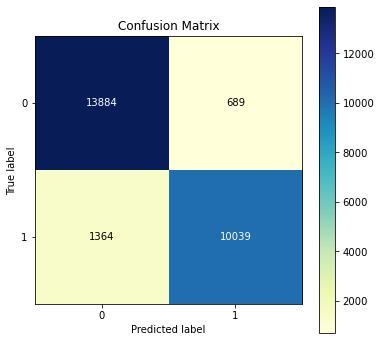

In [168]:
scikitplot.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(6,6), cmap= 'YlGnBu');

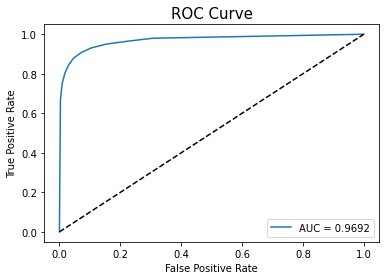

In [176]:
y_pred_proba = knn.predict_proba(X_test_scal)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', size = 15)
plt.legend()

In [186]:
auc

0.9893598301688945

## 2- Decision Tree

### Without Feature Scaling

In [17]:
dtree = DecisionTreeClassifier()
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(dtree, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [18]:
dtree = DecisionTreeClassifier(random_state=0, max_depth=8, min_samples_leaf=4, min_samples_split=2)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=4, random_state=0)

In [19]:
y_pred = dtree.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")

Accuracy Score : 92.69 %


In [20]:
print('F-1 Score : ',(f1_score(y_test, y_pred, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred)))

F-1 Score :  0.92689405605174
Precision Score :  0.92689405605174
Recall Score :  0.92689405605174
Jaccard Score :  0.8637488789237668
Log Loss :  2.5250162930446542


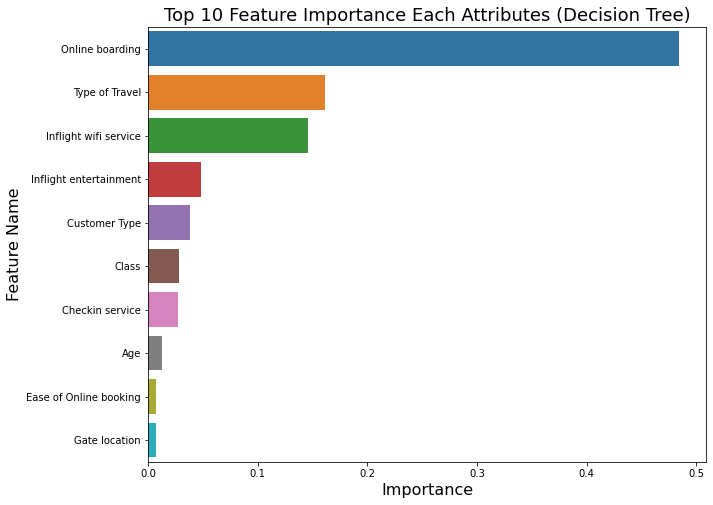

In [23]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": dtree.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Top 10 Feature Importance Each Attributes (Decision Tree)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

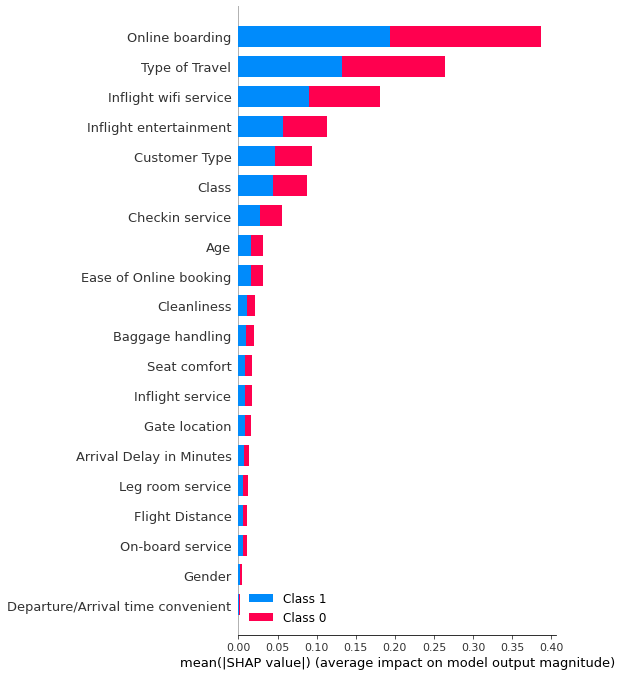

In [24]:
explainer = shap.TreeExplainer(dtree)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

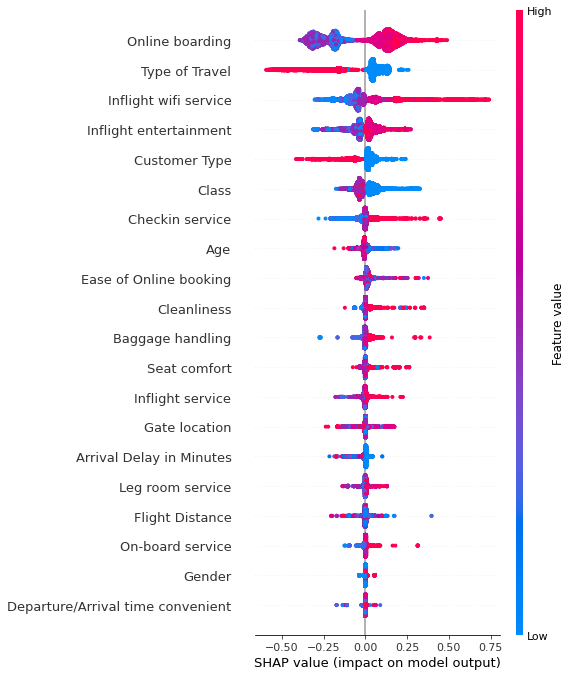

In [25]:
# compute SHAP values
explainer = shap.TreeExplainer(dtree)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test.values, feature_names = X_test.columns)

Text(0.5, 1.0, 'Accuracy Score for Decision Tree: 0.92689405605174')

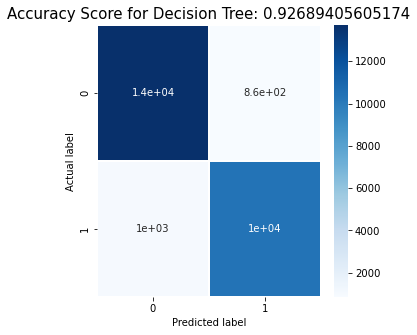

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Decision Tree: {0}'.format(dtree.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

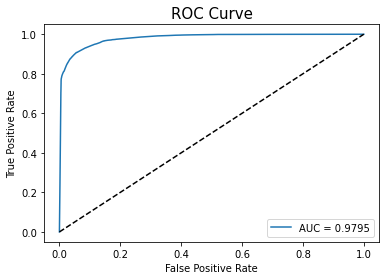

In [29]:
y_pred_proba = dtree.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', size = 15)
plt.legend()

# Ensemble Learning
## 1. Bagging 2. Boosting 3. Stacking

### Bagging

short for Bootstrap Aggregating, is an ensemble learning technique
that involves building multiple models using subsets of the training data
and combining their predictions through a process of aggregation.
In bagging, several subsets of the training data are created by randomly
sampling the original data with replacement. Each subset is used to train a
separate model, which is then combined with the other models to form the
fnal ensemble model.

The aggregation process in bagging can be done by taking the average (for
regression) or the majority vote (for classifcation) of the predictions made
by the individual models. The resulting ensemble model is usually more robust
and accurate than any individual model.

Popular Bagging Models:

There are several popular bagging models in machine learning, including:
1. Random Forest: A decision tree-based model that uses bagging to
create an ensemble of decision trees. Random Forest is a popular model
for classifcation and regression problems.
2. Bagging meta-estimator: A general-purpose bagging model that can be
used with any base estimator, such as decision trees, SVMs, or neural
networks.
3. Extra Trees: An extension of Random Forest that introduces more
randomness into the tree-building process by using random thresholds
for each feature.
4. Bootstrap aggregating for regression (BaggingRegressor): A bagging
model specifcally designed for regression problems.
5. Bootstrap aggregating for classifcation (BaggingClassifer): A bagging
model specifcally designed for classifcation problems

## 3- Random Forest 

Random Forest Classifer is a popular ensemble learning algorithm that
combines multiple decision trees to make predictions for classifcation
problems. It is a type of bagging method that creates multiple decision trees
using a random subset of the features and training data and then combines
the results of these trees to make a prediction.

In a random forest, each decision tree is built on a different bootstrap sample
of the training data, which is created by randomly sampling the training data
with replacement. Additionally, at each split of the tree, only a random
subset of the features is considered for splitting, rather than all the features.
This helps to reduce the correlation between the trees and increases the
diversity of the ensemble.

In [30]:
rfc = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 'log2', None] }

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(rfc, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}


In [31]:
rfc = RandomForestClassifier(random_state=0, max_features='sqrt', n_estimators=200)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [32]:
y_pred = rfc.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")

Accuracy Score : 95.79 %


In [33]:
print('F-1 Score : ',(f1_score(y_test, y_pred, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred)))

F-1 Score :  0.9578842008007391
Precision Score :  0.9578842008007391
Recall Score :  0.9578842008007391
Jaccard Score :  0.919172515700037
Log Loss :  1.4546367594593215


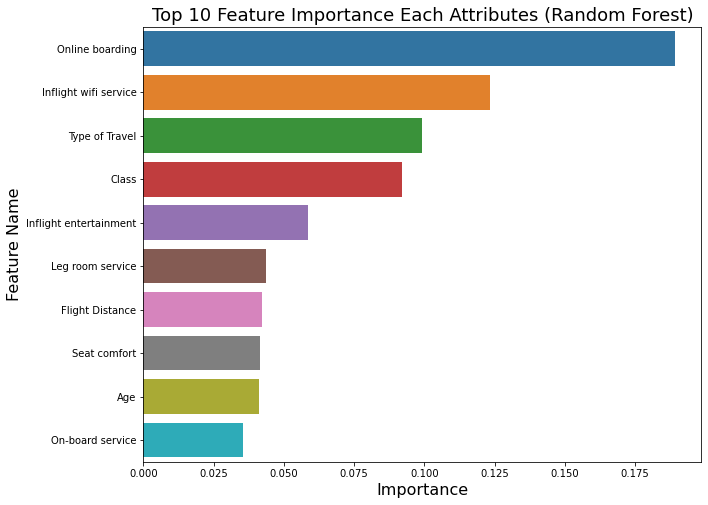

In [34]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": rfc.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Top 10 Feature Importance Each Attributes (Random Forest)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

### ROC Curve for Random forest

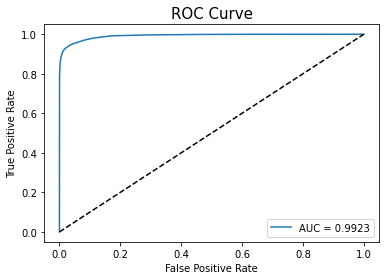

In [178]:
y_pred_proba = rfc.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', size = 15)
plt.legend()

## Permutation Importance

The concept is really straightforward: We measure the importance of a feature by calculating the increase in the model’s prediction error after permuting the feature. A feature is “important” if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction. A feature is “unimportant” if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction. 

Permutation Importance (PI) is an explainability technique used to obtain the importance of features based on their impact on a trained ML model’s prediction. This technique is usually employed during the training and development stage of the MLOps life cycle when data scientists wish to identify the features that have the biggest impact on a model’s predictions for model diagnostics and improvement, such as identifying bias or irrelevant features. PI ignores the internal behavior of the model and focuses only on its prediction performance. Therefore, data scientists are not required to understand the implementation of the model to be able to use PI. PI could be computed on any trained ML model as long as the input data is available.

What features have the biggest impact on predictions?

Permutation importance is calculated after a model has been fitted.

1. Get a trained model.
2. Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
3. Return the data to the original order (undoing the shuffle from step 2). Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.

In [37]:
import eli5
from eli5.sklearn import PermutationImportance

In [40]:
perm = PermutationImportance(RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train),random_state=1).fit(X_train,y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

The values towards the top are the most important features, and those towards the bottom matter least.

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

In [41]:
# Helper Function to run a model
def run_model(model, X_train, y_train, X_test, y_test, fit=True):
    if fit == True:
        model.fit(X_train,y_train)
        
    y_pred = model.predict(X_test)
    
    from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix
    roc_auc = roc_auc_score(y_test, y_pred)

    print("ROC_AUC = {}".format(roc_auc))
    print(classification_report(y_test,y_pred,digits = 5))
    plot_confusion_matrix(model, X_test, y_test,cmap = plt.cm.Blues)
    
    return model, roc_auc

In [42]:
X_train.shape, X_test.shape

((100823, 21), (25976, 21))

In [43]:
y_train.shape, y_test.shape

((100823,), (25976,))

## Decision Tree

To get the Feature Importance

ROC_AUC = 0.9254346082479014
              precision    recall  f1-score   support

           0    0.92975   0.94181   0.93574     14573
           1    0.92438   0.90906   0.91666     11403

    accuracy                        0.92743     25976
   macro avg    0.92707   0.92543   0.92620     25976
weighted avg    0.92739   0.92743   0.92736     25976



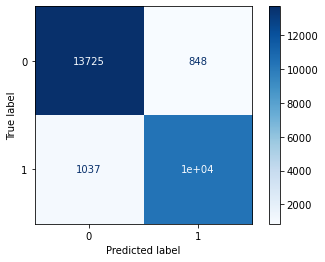

In [50]:
model_df = DecisionTreeClassifier(random_state = 42, max_depth = 8)
model_df, roc_auc_df = run_model(model_df, X_train, y_train, X_test, y_test)

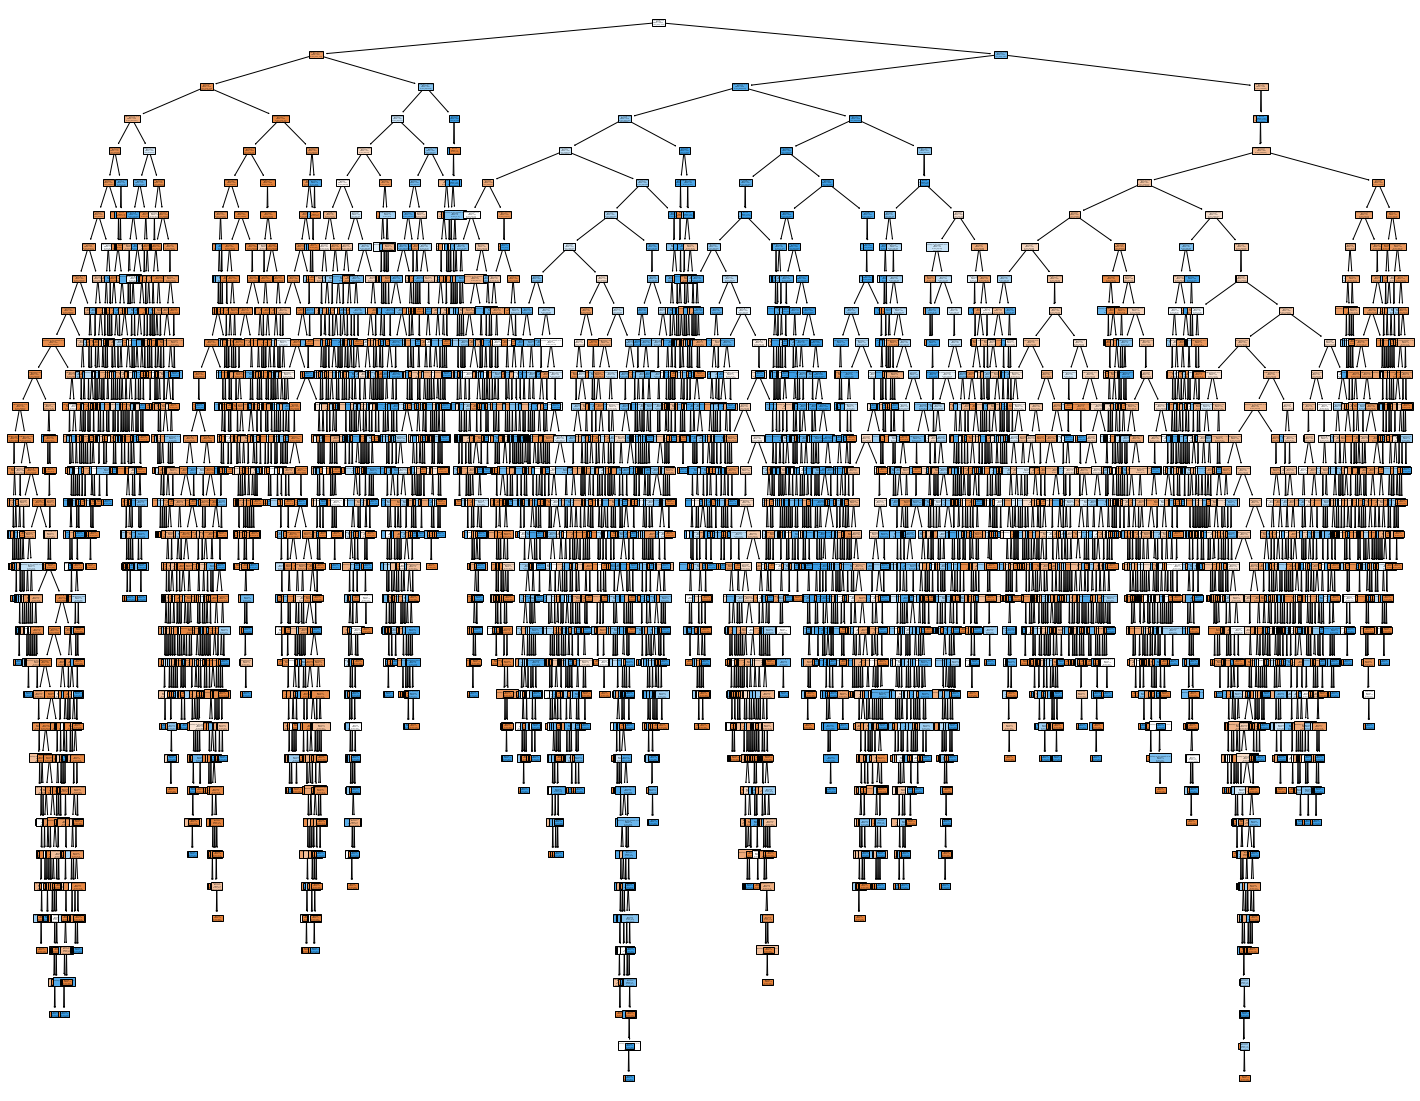

In [48]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(model_df, 
              feature_names = X_train.columns,
              class_names = ['no satisfied', 'satisfied'],
              filled=True)

ROC_AUC = 0.9349034049873375
              precision    recall  f1-score   support

           0    0.93970   0.94751   0.94359     14573
           1    0.93219   0.92230   0.92722     11403

    accuracy                        0.93644     25976
   macro avg    0.93595   0.93490   0.93540     25976
weighted avg    0.93641   0.93644   0.93640     25976



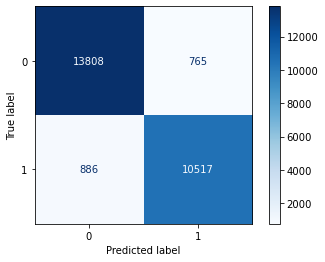

In [51]:
model_df = DecisionTreeClassifier(random_state = 42)
model_df, roc_auc_df = run_model(model_df, X_train, y_train, X_test, y_test)

## Feature importance

In [52]:
# each model after training has a feature importance
model_df.feature_importances_

array([0.00397932, 0.03989381, 0.03211223, 0.13259414, 0.02783242,
       0.03953804, 0.12943648, 0.00757524, 0.01187455, 0.01738647,
       0.005614  , 0.38830751, 0.01779116, 0.04233073, 0.01002272,
       0.00997093, 0.01689638, 0.02848399, 0.01598601, 0.01215877,
       0.0102151 ])

In [54]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

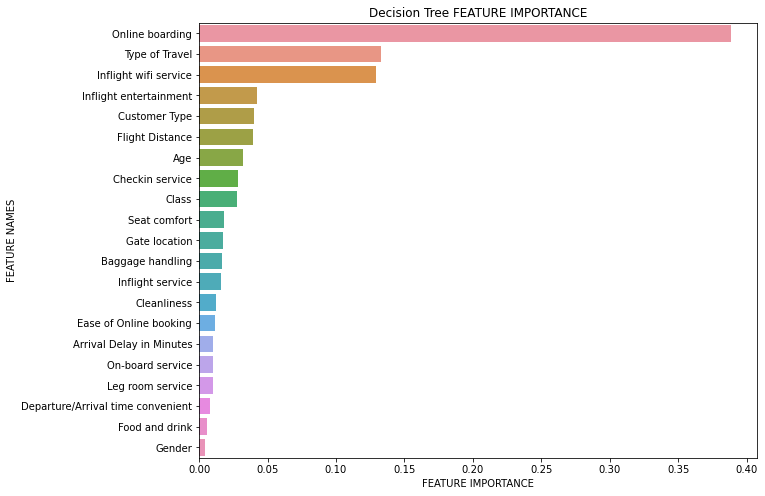

In [55]:
plot_feature_importance(model_df.feature_importances_, X_train.columns, 'Decision Tree')

In [180]:
# drop columns that are not that important
newData = data.drop(['Gender', 'Food and drink', 'Departure/Arrival time convenient', 'Leg room service',
                'On-board service', 'Arrival Delay in Minutes' , 'Ease of Online booking'], axis = 1)
newTestData = test_data.drop(['Gender', 'Food and drink', 'Departure/Arrival time convenient', 'Leg room service',
                'On-board service', 'Arrival Delay in Minutes' , 'Ease of Online booking'], axis = 1)

In [181]:
X_new, y_new = newData.drop(["satisfaction"], axis = 1), newData['satisfaction']

In [182]:
X_train = newData.drop('satisfaction', axis = 1)
y_train = newData.satisfaction

X_test = newTestData.drop('satisfaction', axis=1)
y_test = newTestData.satisfaction

# Use this new Dataset

## Boosting

Boosting is an ensemble learning technique that combines multiple weak
learners to create a strong learner. In contrast to bagging methods like
Random Forest and Extra Trees, which create multiple models
independently and combine their results, boosting methods build a
sequence of models iteratively, with each subsequent
model trying to improve upon the errors of the previous model.

The basic idea of boosting is to assign higher weights to the samples that
are misclassifed by the previous model so that the subsequent model focuses
more on these samples. The process is repeated iteratively, with each
subsequent model trying to correct the mistakes of the previous models.
The fnal prediction is a weighted combination of the predictions of all the
models in the sequence.

Boosting methods are particularly effective in situations where the data has
many features or where the signal-to-noise ratio is low. They are widely used
in applications such as natural language processing, computer vision, and
fnance, among others.

Boosting Models
There are several types of boosting methods, including:
1. AdaBoost: Adaboost is a popular boosting algorithm that assigns
higher weights to the misclassifed samples and trains subsequent
models to focus on these samples. The weights are updated iteratively,
and the fnal prediction is a weighted sum of the predictions of all the
models in the sequence.
2. Gradient Boosting: Gradient boosting is a boosting algorithm that
iteratively trains models to correct the residuals (i.e., the errors) of the
previous models. The fnal prediction is a sum of the predictions of all
the models in the sequence.
3. XGBoost: XGBoost is an optimized implementation of gradient boosting
that uses a regularized objective function and parallel processing to
improve performance and reduce overftting.
4. LGBM Classifer: LightGBM (LGBM) is a popular gradient-boosting
framework that was developed by Microsoft. It is designed to be fast,
scalable, and highly effcient for large-scale data and is known for its
ability to handle large datasets.

Parallel Processing in XGBOOST: XGBoost can perform parallel processing in
two ways: data parallelism and task parallelism. Data parallelism involves
partitioning the dataset into smaller subsets and training multiple models on
each subset in parallel. Task parallelism involves parallelizing the
computations within a single model, such as parallelizing the gradient
computation.
To enable parallel processing in XGBoost, you can set the n_jobs parameter to
specify the number of CPU cores to use. For example, setting n_jobs=-1 will
use all available CPU cores for parallel processing.


### What are the main differences between XGBOOST, Gradient Boosting, LGBM, and Adaboost?
All XGBoost, Gradient Boosting, LightGBM (LGBM), and AdaBoost are ensemble
methods that use boosting to improve the accuracy of machine learning
models. However, there are some key differences between them.

1. XGBoost (Extreme Gradient Boosting): XGBoost is a popular
implementation of gradient boosting that was designed to improve
upon the original gradient boosting algorithm. XGBoost uses a
regularized objective function and a distributed computing framework
(Parallel Processing) to achieve faster and more accurate results than
traditional gradient boosting. It also includes features such as tree
pruning and handling missing data.
2. Gradient Boosting: Gradient Boosting is a general technique for
improving the accuracy of machine learning models by combining
multiple weak models. It works by iteratively training new models on
the errors of the previous models and adding them to the ensemble.
Gradient Boosting is a powerful technique, but it can be slow and
prone to overftting.
3. LightGBM (Light Gradient Boosting Machine): LightGBM is another
implementation of gradient boosting that was designed to be faster
and more memory-effcient than other methods. It uses a histogrambased approach to split data and reduces the time required for sorting,making it well-suited for large datasets. LightGBM also includes
features such as GPU acceleration and distributed training.
4. AdaBoost (Adaptive Boosting): AdaBoost is a boosting algorithm that
works by weighting the training data and focusing on the misclassifed
samples. It trains weak models on the weighted data and combines
them into an ensemble. AdaBoost is a simple and effective algorithm,
but it can be sensitive to noisy data.

In summary, while all these algorithms use boosting to improve the
accuracy of machine learning models, they differ in their implementation
details and optimization techniques. XGBoost and LightGBM are known for
their speed and performance on large datasets, while Gradient Boosting and
AdaBoost are more widely used and provide a good balance between accuracy
and simplicity.

## 4- XGboost classifier


Parallel Processing in XGBOOST: XGBoost can perform parallel processing in
two ways: data parallelism and task parallelism. Data parallelism involves
partitioning the dataset into smaller subsets and training multiple models on
each subset in parallel. Task parallelism involves parallelizing the
computations within a single model, such as parallelizing the gradient
computation.
To enable parallel processing in XGBoost, you can set the n_jobs parameter to
specify the number of CPU cores to use. For example, setting n_jobs=-1 will
use all available CPU cores for parallel processing

In [72]:
#My_classifier
xgb = XGBClassifier(scale_pos_weight=1, 
                      colsample_bytree = 0.4,
                      learning_rate=0.02,
                       max_depth=11,
                      n_estimators=900,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      reg_alpha = 0.3,)

full_pipline1 = Pipeline(steps=[('my_classifier', xgb,)] )
full_pipline1

Pipeline(steps=[('my_classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.4, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.02,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=11, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=900,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

ROC_AUC = 0.9476057990087
              precision    recall  f1-score   support

           0    0.94165   0.97221   0.95668     14573
           1    0.96295   0.92300   0.94255     11403

    accuracy                        0.95061     25976
   macro avg    0.95230   0.94761   0.94962     25976
weighted avg    0.95100   0.95061   0.95048     25976



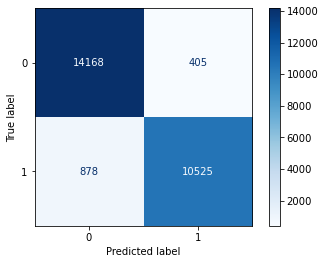

In [73]:
model_xgboost, roc_auc_xgboost = run_model(full_pipline1, X_train, y_train, X_test, y_test)

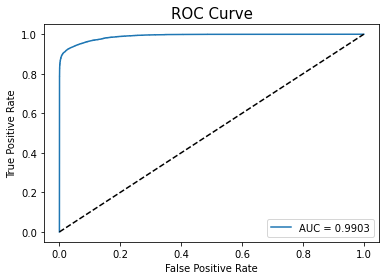

In [183]:
y_pred_proba = model_xgboost.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', size = 15)
plt.legend()

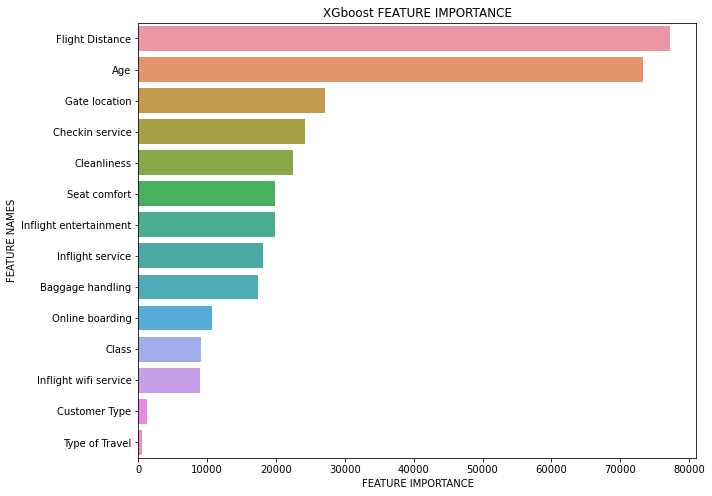

In [78]:
plot_feature_importance(list(model_xgboost[0].get_booster().get_score(importance_type='weight').values()),
                        X_train.columns, 'XGboost')

In [79]:
model_xgboost  # the whole pipeline , [0] to get the xgboost model

Pipeline(steps=[('my_classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.4, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.02,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=11, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=900,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

# Hyperparameter Tuning

## XGboost , Grid Search with cross validation

In [82]:
# here we specify the search space
param_grid = {
      'my_classifier__n_estimators': [500,700],     
       'my_classifier__max_depth':[8,11] ,
     
}
# cv=10 means ten-fold cross-validation

grid_search = GridSearchCV(
    full_pipline1, param_grid, cv=10, verbose=1, n_jobs=2, 
    scoring='roc_auc')

grid_search.fit(X_train, y_train)
print('best score {}'.format(grid_search.best_score_))
print('best score {}'.format(grid_search.best_params_))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
best score 0.9942573898514298
best score {'my_classifier__max_depth': 11, 'my_classifier__n_estimators': 700}


ROC_AUC = 0.9466432648403166
              precision    recall  f1-score   support

           0    0.94194   0.96967   0.95560     14573
           1    0.95972   0.92362   0.94132     11403

    accuracy                        0.94945     25976
   macro avg    0.95083   0.94664   0.94846     25976
weighted avg    0.94975   0.94945   0.94934     25976



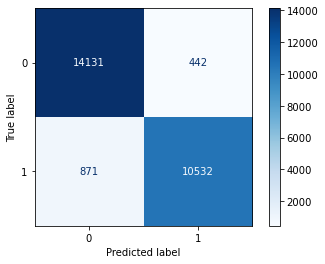

In [184]:
# Run the model on test data and get the results
# fit=False cause it's already fitted to the train data with the best hyperparameters
model_xgboost, roc_auc_xgboost = run_model(grid_search, X_train, y_train, X_test, y_test , fit = False)

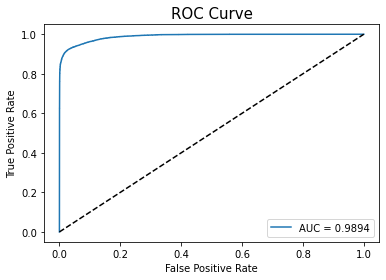

In [185]:
y_pred_proba = model_xgboost.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', size = 15)
plt.legend()

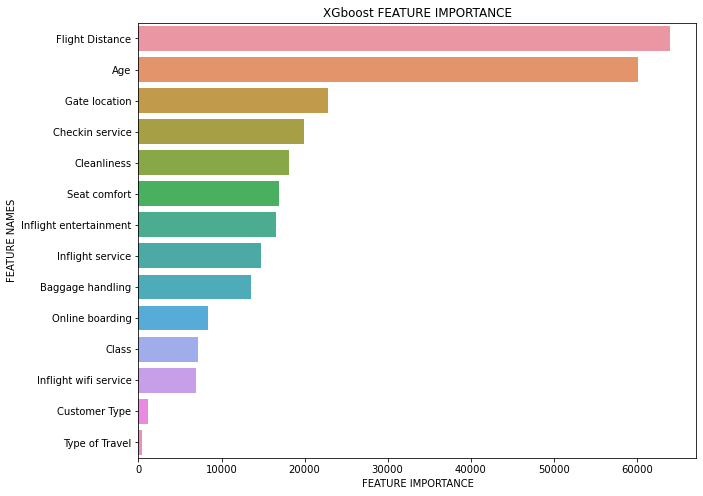

In [87]:
plot_feature_importance(list(grid_search.best_estimator_[0].get_booster().get_score(importance_type='weight').values()),
                        X_train.columns, 'XGboost')

# Automated Machine Learning

Automated Machine Learning (AutoML) refers to techniques for automatically discovering well-performing models for predictive modeling tasks with very little user involvement.

## 1. Hyperopt

https://machinelearningmastery.com/hyperopt-for-automated-machine-learning-with-scikit-learn/

HyperOpt is an open-source library for large scale AutoML and HyperOpt-Sklearn is a wrapper for HyperOpt that supports AutoML with HyperOpt for the popular Scikit-Learn machine learning library, including the suite of data preparation transforms and classification and regression algorithms.

It is designed for large-scale optimization for models with hundreds of parameters and allows the optimization procedure to be scaled across multiple cores and multiple machines.

The library was explicitly used to optimize machine learning pipelines, including data preparation, model selection, and model hyperparameters.

Hyperopt-Sklearn is an open-source library for AutoML with scikit-learn data preparation and machine learning models.

Hyperopt-Sklearn to automatically discover top-performing models for classification and regression tasks.

In [90]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.uniform("max_depth", 3, 18),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.8, 1),
        'seed': 0   }

In [101]:
def objective(space):
    clf= XGBClassifier(scale_pos_weight=1,
                      learning_rate=0.02,
                       max_depth = int(space['max_depth']),
                      n_estimators=700, subsample = 0.8,
                      objective='binary:logistic', 
                      reg_alpha = 0.3,
                    colsample_bytree=space['colsample_bytree'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="aucpr",verbose=  False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [102]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 15,
                        trials = trials)

SCORE:                                                                                                                 
0.953264551894056                                                                                                      
SCORE:                                                                                                                 
0.9535340314136126                                                                                                     
SCORE:                                                                                                                 
0.954111487526948                                                                                                      
SCORE:                                                                                                                 
0.9533800431167231                                                                                                     
SCORE:                                  

In [103]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8611038507301207, 'max_depth': 10.194838906643845}


In [104]:
clf= XGBClassifier(max_depth = int(best_hyperparams['max_depth']),
                    colsample_bytree=best_hyperparams['colsample_bytree'])

ROC_AUC = 0.9486810721353676
              precision    recall  f1-score   support

           0    0.94350   0.97173   0.95741     14573
           1    0.96243   0.92563   0.94367     11403

    accuracy                        0.95149     25976
   macro avg    0.95297   0.94868   0.95054     25976
weighted avg    0.95181   0.95149   0.95138     25976



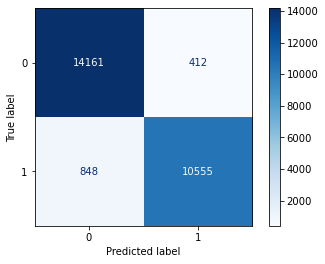

In [105]:
model_xgboost, roc_auc_xgboost = run_model(clf, X_train, y_train, X_test, y_test)

## 2. Optuna 

https://towardsdatascience.com/state-of-the-art-machine-learning-hyperparameter-optimization-with-optuna-a315d8564de1

a hyperparameter optimization software framework, particularly designed for machine learning pipelines. Optuna enables users to adopt state-of-the-art algorithms for sampling hyperparameters and pruning unpromising trials. This helps to speed up optimization time and performance greatly compared to traditional methods such as GridSearch. It also allows users to plot optimization histories for a better understanding of the model.

In [107]:
import optuna

In [ ]:
def objective(trial):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 18),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.8, 1.0),
        'subsample': trial.suggest_float("subsample", 0.6, 1.0),
    }
    
    model = XGBClassifier(**param)     
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)], eval_metric="aucpr",verbose=False)
    
    preds = model.predict(test_x)    
    accuracy = accuracy_score(test_y, preds)
    
    return accuracy

In [121]:
def objective(trial):
    
    param = {
            'max_depth': trial.suggest_int('max_depth', 3, 18),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.8, 1.0),
            'subsample': trial.suggest_float("subsample", 0.6, 1.0),
    }
    
    model = XGBClassifier(**param , n_estimators=700,)     
    full_pipline1 = Pipeline(steps=[('my_classifier', model,)] )
    
    full_pipline1.fit(X_train,y_train)
    
    preds = model.predict(X_test)    
    accuracy = accuracy_score(y_test, preds)
    
    return accuracy

In [127]:
def objective(trial):
    
    param = {
            'max_depth': trial.suggest_int('max_depth', 3, 18),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.8, 1.0),
            'subsample': trial.suggest_float("subsample", 0.6, 1.0),
    }
    
    model = XGBClassifier(**param , n_estimators=700,)     
    full_pipline1 = Pipeline(steps=[('my_classifier', model,)] )
    
    full_pipline1.fit(X_train,y_train, my_classifier__eval_set=[(X_test,y_test)], my_classifier__eval_metric="aucpr",
                      my_classifier__verbose=False)
    
    preds = model.predict(X_test)    
    accuracy = accuracy_score(y_test, preds)
    
    return accuracy

In [128]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-04-24 15:34:02,075] A new study created in memory with name: no-name-650f7115-c277-44ba-85ec-db02e798d076
[I 2023-04-24 15:35:23,526] Trial 0 finished with value: 0.949183862026486 and parameters: {'max_depth': 17, 'colsample_bytree': 0.9853671395916498, 'subsample': 0.950152179486164}. Best is trial 0 with value: 0.949183862026486.
[I 2023-04-24 15:36:45,438] Trial 1 finished with value: 0.9493763473975978 and parameters: {'max_depth': 14, 'colsample_bytree': 0.9631000932148274, 'subsample': 0.811485218661197}. Best is trial 1 with value: 0.9493763473975978.
[I 2023-04-24 15:38:38,864] Trial 2 finished with value: 0.9498768093624884 and parameters: {'max_depth': 18, 'colsample_bytree': 0.9026663812466311, 'subsample': 0.9339599797580704}. Best is trial 2 with value: 0.9498768093624884.
[I 2023-04-24 15:40:41,439] Trial 3 finished with value: 0.9486064059131506 and parameters: {'max_depth': 14, 'colsample_bytree': 0.8626839433323472, 'subsample': 0.900912855546498}. Best is tri

Number of finished trials: 30
Best trial: {'max_depth': 18, 'colsample_bytree': 0.8282721374798547, 'subsample': 0.9886457141797518}


In [129]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.949184 2023-04-24 15:34:02.077486 2023-04-24 15:35:23.526008   
1        1  0.949376 2023-04-24 15:35:23.528013 2023-04-24 15:36:45.438763   
2        2  0.949877 2023-04-24 15:36:45.440770 2023-04-24 15:38:38.863579   
3        3  0.948606 2023-04-24 15:38:38.866588 2023-04-24 15:40:41.438089   
4        4  0.948722 2023-04-24 15:40:41.441747 2023-04-24 15:42:43.638476   
5        5  0.948799 2023-04-24 15:42:43.641485 2023-04-24 15:43:25.100705   
6        6  0.949184 2023-04-24 15:43:25.102711 2023-04-24 15:44:29.501790   
7        7  0.950339 2023-04-24 15:44:29.503797 2023-04-24 15:46:41.161291   
8        8  0.948876 2023-04-24 15:46:41.164299 2023-04-24 15:48:11.365094   
9        9  0.948722 2023-04-24 15:48:11.368111 2023-04-24 15:50:13.661396   
10      10  0.947875 2023-04-24 15:50:13.663222 2023-04-24 15:51:40.345662   
11      11  0.949338 2023-04-24 15:51:40.348671 2023-04-24 15:53:55.732969   
12      12  0.949684 2023-04-24 15:53:55.735977 2023-04-24 15:56:00.187559   
13      13  0.949030 2023-04-24 15:56:00.190094 2023-04-24 15:58:09.938994   
14      14  0.949684 2023-04-24 15:58:09.942836 2023-04-24 16:00:17.334673   
15      15  0.948298 2023-04-24 16:00:17.337851 2023-04-24 16:00:49.533274   
16      16  0.948799 2023-04-24 16:00:49.535281 2023-04-24 16:03:03.258987   
17      17  0.949222 2023-04-24 16:03:03.261996 2023-04-24 16:04:48.518780   
18      18  0.948260 2023-04-24 16:04:48.522841 2023-04-24 16:05:55.095772   
19      19  0.949415 2023-04-24 16:05:55.099590 2023-04-24 16:08:16.908073   
20      20  0.948606 2023-04-24 16:08:16.910574 2023-04-24 16:10:22.605239   
21      21  0.949530 2023-04-24 16:10:22.608722 2023-04-24 16:12:28.296854   
22      22  0.950108 2023-04-24 16:12:28.304921 2023-04-24 16:14:30.694958   
23      23  0.949607 2023-04-24 16:14:30.697967 2023-04-24 16:16:41.782113   
24      24  0.949800 2023-04-24 16:16:41.785121 2023-04-24 16:18:41.690051   
25      25  0.950185 2023-04-24 16:18:41.693960 2023-04-24 16:20:51.422441   
26      26  0.948760 2023-04-24 16:20:51.426344 2023-04-24 16:22:47.639771   
27      27  0.949684 2023-04-24 16:22:47.642779 2023-04-24 16:24:57.374168   
28      28  0.949492 2023-04-24 16:24:57.377177 2023-04-24 16:26:33.608057   
29      29  0.948837 2023-04-24 16:26:33.611066 2023-04-24 16:28:41.942331   

                 duration  params_colsample_bytree  params_max_depth  \
0  0 days 00:01:21.448522                 0.985367                17   
1  0 days 00:01:21.910750                 0.963100                14   
2  0 days 00:01:53.422809                 0.902666                18   
3  0 days 00:02:02.571501                 0.862684                14   
4  0 days 00:02:02.196729                 0.948312                12   
5  0 days 00:00:41.459220                 0.945982                 4   
6  0 days 00:01:04.399079                 0.906250                 7   
7  0 days 00:02:11.657494                 0.828272                18   
8  0 days 00:01:30.200795                 0.802379                10   
9  0 days 00:02:02.293285                 0.920756                13   
10 0 days 00:01:26.682440                 0.850948                 9   
11 0 days 00:02:15.384298                 0.874709                18   
12 0 days 00:02:04.451582                 0.824296                16   
13 0 days 00:02:09.748900                 0.883913                18   
14 0 days 00:02:07.391837                 0.901999                15   
15 0 days 00:00:32.195423                 0.842096                 3   
16 0 days 00:02:13.723706                 0.881439                16   
17 0 days 00:01:45.256784                 0.833616                12   
18 0 days 00:01:06.572931                 0.810619                 7   
19 0 days 00:02:21.808483                 0.858116                18   
20 0 days 00:02:05.694665                 0.833175                16   
2

In [130]:
optuna.visualization.plot_optimization_history(study)

In [131]:
optuna.visualization.plot_param_importances(study)

In [132]:
Best_trial = study.best_trial.params
Best_trial

{'max_depth': 18,
 'colsample_bytree': 0.8282721374798547,
 'subsample': 0.9886457141797518}

In [133]:
clf = XGBClassifier(**Best_trial)

ROC_AUC = 0.9483092222285228
              precision    recall  f1-score   support

           0    0.94224   0.97283   0.95729     14573
           1    0.96377   0.92379   0.94336     11403

    accuracy                        0.95130     25976
   macro avg    0.95301   0.94831   0.95032     25976
weighted avg    0.95169   0.95130   0.95117     25976



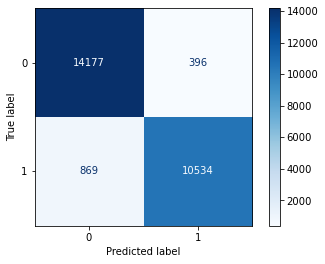

In [134]:
model_xgboost, roc_auc_xgboost = run_model(clf, X_train, y_train, X_test, y_test)

## Save the model

Save to pickled file using joblib

In [135]:
import joblib
  
# Save the model as a pickle in a file
joblib.dump(model_xgboost, 'model_xgboost_optuna.pkl')

['model_xgboost_optuna.pkl']

## Stacking

A stacking classifier is an ensemble learning method that combines multiple classification models to create one “super” model. This can often lead to improved performance, since the combined model can learn from the strengths of each individual model

Stacking is one of the most popular ensemble machine learning techniques used to predict multiple nodes to build a new model and improve model performance. Stacking enables us to train multiple models to solve similar problems, and based on their combined output, it builds a new model with improved performance.

Stacking is an ensemble learning technique that involves combining
multiple machine learning models to improve the accuracy of predictions. It
is a meta-learning approach that works by training multiple base models on
the same data and then using a meta-model to combine their
predictions.

Once the meta-model is trained, it can be used to make predictions on the
test set. The fnal output is a combination of predictions from the base
models and the meta-model.

The main advantage of stacking is that it can often produce more accurate
predictions than using a single model by Combining the predictions from
multiple models, can reduce the bias and variance of the overall model and
improve the overall performance.

However, stacking can also be more computationally expensive
and require more data than other ensemble methods like bagging and
boosting. It also requires careful tuning of the hyperparameters of both the
base models and the meta-model.

Overall, stacking is a powerful technique for improving the accuracy of
machine learning models, but it requires careful implementation and tuning to
achieve the best results.

Stacking Models:

1. Stacking Classifer: The Stacking Classifer works by splitting the data
into training and validation sets. The base classifers are then trained
on the training set and their predictions are made on the validation
set. These predictions are used as input to the meta-classifer, which
is trained on the validation set labels.

Do a RandomForestClassifier and KNeighborsClassifier so we can stack them with XGboost

ROC_AUC = 0.9482612610073786
              precision    recall  f1-score   support

           0    0.93989   0.97633   0.95776     14573
           1    0.96817   0.92020   0.94357     11403

    accuracy                        0.95169     25976
   macro avg    0.95403   0.94826   0.95067     25976
weighted avg    0.95230   0.95169   0.95153     25976



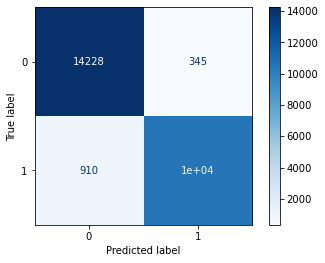

In [136]:
model_rf = RandomForestClassifier(random_state = 42)
model_rf, roc_auc_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

ROC_AUC = 0.7839668423918871
              precision    recall  f1-score   support

           0    0.81917   0.79112   0.80490     14573
           1    0.74424   0.77681   0.76018     11403

    accuracy                        0.78484     25976
   macro avg    0.78171   0.78397   0.78254     25976
weighted avg    0.78628   0.78484   0.78527     25976



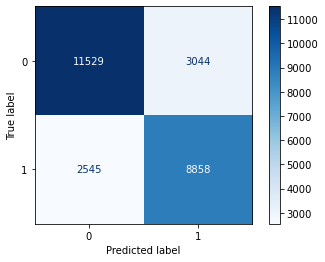

In [140]:
knn = KNeighborsClassifier(n_neighbors= 8, weights= 'distance')
model_knn, roc_auc_knn = run_model(knn, X_train, y_train, X_test, y_test)

Now let's stack them

1. Stacking Classifer: The Stacking Classifer works by splitting the data
into training and validation sets. The base classifers are then trained
on the training set and their predictions are made on the validation
set. These predictions are used as input to the meta-classifer, which
is trained on the validation set labels.

In [141]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('knn', model_knn),
    ('rf', model_rf),
    ('xgboost', model_xgboost)
]

clf = StackingClassifier(
         estimators=estimators, final_estimator=LogisticRegression()
)

In [142]:
clf.fit(X_train, y_train)

StackingClassifier(estimators=[('knn',
                                KNeighborsClassifier(n_neighbors=8,
                                                     weights='distance')),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8282721374798547,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_me...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=18,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   final_estimator=LogisticRegression())

ROC_AUC = 0.9486480739727396
              precision    recall  f1-score   support

           0    0.93896   0.97859   0.95837     14573
           1    0.97108   0.91871   0.94417     11403

    accuracy                        0.95230     25976
   macro avg    0.95502   0.94865   0.95127     25976
weighted avg    0.95306   0.95230   0.95213     25976



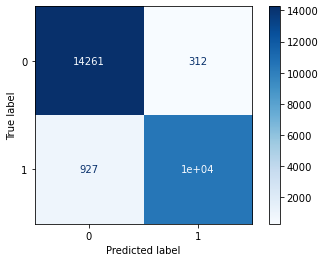

In [143]:
model_stacking, roc_auc_stacking = run_model(clf, X_train, y_train, X_test, y_test, False)

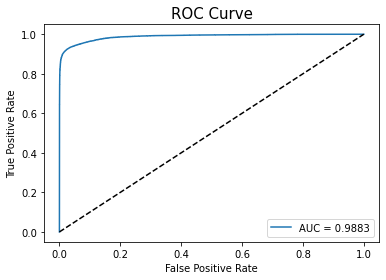

In [187]:
y_pred_proba = model_stacking.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', size = 15)
plt.legend()

## 3. AutoML

https://www.analyticsvidhya.com/blog/2021/10/beginners-guide-to-automl-with-an-easy-autogluon-example/

AutoGluon automates machine learning tasks enabling you to easily achieve strong predictive performance in your applications. With just a few lines of code, you can train and deploy high-accuracy machine learning and deep learning models on image, text, time series, and tabular data.

AutoML model aims to automate all time-consuming operations like the selection of algorithms, writing the code, pipeline development, and hyperparameter tuning.

In [145]:
# !pip install autogluon.tabular[all] -q --progress-bar off
#!pip install opencensus

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rembg 2.0.24 requires scipy==1.7.3, but you have scipy 1.9.3 which is incompatible.


In [146]:
from autogluon.tabular import TabularPredictor

We will use the data trainig and testing(validation) without splitting into x and y :

newData ,, newTestData

In [147]:
hyperparameters = {
   'GBM': {},
   'RF': {},
   'KNN': {}
}

In [150]:
autogluon_predictor = TabularPredictor(
    label = 'satisfaction',
    eval_metric = "roc_auc",
    learner_kwargs = {'ignored_columns': ['id']}
).fit(
    train_data = newData,
    hyperparameters = hyperparameters,
    verbosity = 2,
    presets = 'best_quality',
    time_limit = 60 * 5,
)

No path specified. Models will be saved in: "AutogluonModels\ag-20230424_151134\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels\ag-20230424_151134\"
AutoGluon Version:  0.7.0
Python Version:     3.8.5
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.16299
Train Data Rows:    100823
Train Data Columns: 14
Label Column: satisfaction
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess

In [151]:
leaderbord = autogluon_predictor.leaderboard(newTestData)

                 model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2    0.989094   0.996457       29.825480      59.395032  216.227556                 0.003009                0.017018           5.556003            2       True          4
1  RandomForest_BAG_L1    0.988813   0.996341        0.498174       1.152066    4.702501                 0.498174                1.152066           4.702501            1       True          3
2      LightGBM_BAG_L1    0.988587   0.984826       29.017083      57.302951  204.829021                29.017083               57.302951         204.829021            1       True          2
3    KNeighbors_BAG_L1    0.839915   0.889902        0.307215       0.922997    1.140031                 0.307215                0.922997           1.140031            1       True          1


In [152]:
leaderbord

model  score_test  score_val  pred_time_test  pred_time_val  \
0  WeightedEnsemble_L2    0.989094   0.996457       29.825480      59.395032   
1  RandomForest_BAG_L1    0.988813   0.996341        0.498174       1.152066   
2      LightGBM_BAG_L1    0.988587   0.984826       29.017083      57.302951   
3    KNeighbors_BAG_L1    0.839915   0.889902        0.307215       0.922997   

     fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0  216.227556                 0.003009                0.017018   
1    4.702501                 0.498174                1.152066   
2  204.829021                29.017083               57.302951   
3    1.140031                 0.307215                0.922997   

   fit_time_marginal  stack_level  can_infer  fit_order  
0           5.556003            2       True          4  
1           4.702501            1       True          3  
2         204.829021            1       True          2  
3           1.140031            1       True          1